In [1]:
import sys, os, pickle, time, json, yaml, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import numpy as np
import pandas as pd
import scipy as sp
from array import array
import root_numpy as rtnp
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from scipy.stats import chi2 as scipy_chi2
from histo_utilities import create_TH1D, make_ratio_plot, create_TH2D, std_color_list, rootTH1_to_np
from pileup_utilities import pileupReweighter
from beamSpot_calibration import doubleCrystalball, getBeamSpotWeights, getBeamSpotCorrectionWeights
from categoriesDef import categories as categoriesDef
donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + 'Simulation Internal'

In [3]:
category = 'Mid'
vtxReference = 'bs'
# vtxReference = 'mean'
version = 'v2_'+vtxReference
webDir = os.environ['HOME'] + '/public_html/BPH_RDst/beamSpotCalibration/'+version
if not os.path.isdir(webDir):
    os.makedirs(webDir)
    os.system('cp {d}/../index.php {d}/'.format(d=webDir))

In [4]:
MCsample = {
######## Signals
'mu': DSetLoader('Bd_MuNuDst', candDir='ntuples_B2DstMu_220225'),
'JpsiKst': DSetLoader('Bd_JpsiKst_General', candDir='ntuples_Bd2JpsiKst_220217')
}

df = {}
df['mu'] = pd.DataFrame(rtnp.root2array(MCsample['mu'].skimmed_dir + '/'+category+'_bare.root'))
skimmedFile_loc = MCsample['mu'].skimmed_dir + '/{}_{}.root'.format(category, 'bare')
puReweighter = pileupReweighter(skimmedFile_loc, 'hAllNTrueIntMC', trg=categoriesDef[category.lower()].trg)
df['mu']['w'] = puReweighter.getPileupWeights(df['mu']['MC_nInteractions'])

df['JpsiKst'] = pd.DataFrame(rtnp.root2array(MCsample['JpsiKst'].skimmed_dir + '/'+category+'_bare.root'))
skimmedFile_loc = MCsample['JpsiKst'].skimmed_dir + '/{}_{}.root'.format(category, 'bare')
puReweighter = pileupReweighter(skimmedFile_loc, 'hAllNTrueIntMC', trg=categoriesDef[category.lower()].trg)
df['JpsiKst']['w'] = puReweighter.getPileupWeights(df['JpsiKst']['MC_nInteractions'])

dataLoc = '/storage/af/group/rdst_analysis/BPhysics/data/cmsRD/'
df['data'] = pd.DataFrame(rtnp.root2array(
    dataLoc+'skimmed/B2DstMu_220220_'+category+'_corr.root'))

df['data_JpsiKst'] = pd.DataFrame(rtnp.root2array(
    dataLoc+'skimmed/B2JpsiKst_220217_'+category+'_corr.root'))

[pileup reweighting] wMax=1.9, wMin=0.0
[pileup reweighting] wMax=100.7, wMin=0.0


Warning in <TFile::Init>: file /storage/af/group/rdst_analysis/BPhysics/data/PileupHistograms/Mu9_IP6_allParts.root probably not closed, trying to recover
Info in <TFile::Recover>: /storage/af/group/rdst_analysis/BPhysics/data/PileupHistograms/Mu9_IP6_allParts.root, recovered key TH1D:pileup at address 264
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /storage/af/group/rdst_analysis/BPhysics/data/PileupHistograms/Mu9_IP6_allParts.root probably not closed, trying to recover
Info in <TFile::Recover>: /storage/af/group/rdst_analysis/BPhysics/data/PileupHistograms/Mu9_IP6_allParts.root, recovered key TH1D:pileup at address 264
Warning in <TFile::Init>: successfully recovered 1 keys


In [5]:
binning = {}
binning['q2'] = [0, 3.5, 6, 9.4, 12]

negSide = [-2.5, -1.5, -1.0, -0.6, -0.4, -0.2]
binning['M2_miss'] = [
    negSide + [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 4],
    negSide + [0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.5, 0.2)) + [8],
    negSide + list(np.arange(0, 6, 0.2)) + [8],
    negSide + list(np.arange(0, 7.8, 0.2)) + [8],
]

In [6]:
# Create centered values
for n in ['JpsiKst', 'mu', 'data', 'data_JpsiKst']:
    for a in ['x', 'y']:
        df[n]['vtxC_'+a] = 1e4*(df[n]['vtx_PV_'+a] - np.mean(df[n]['vtx_PV_'+a]))
        df[n]['vtxCbs_'+a] = 1e4*(df[n]['vtx_PV_'+a] - df[n]['beamSpot_'+a])
        print n, a, np.mean(df[n]['vtx_PV_'+a]), np.mean(df[n]['beamSpot_'+a])

JpsiKst x 0.0107714001573 0.0107795996591
JpsiKst y 0.0417417291965 0.0418930016458
mu x 0.0107659620618 0.0107795996591
mu y 0.0417433964845 0.0418930016458
data x 0.0963909439452 0.096429834659
data y -0.0615345818185 -0.0615011566759
data_JpsiKst x 0.0963865230242 0.09643138079
data_JpsiKst y -0.0615288494749 -0.0614992983772


# Draw plots

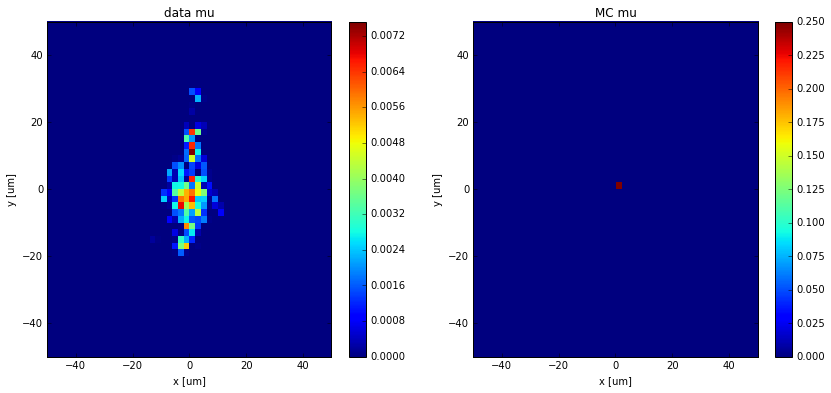

In [7]:
bounds = ((-50, 50), (-50, 50))
# bounds=None
nBins = 50
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
x = 1e4*(df['data']['beamSpot_x'] - np.mean(df['data']['beamSpot_x']))
y = 1e4*(df['data']['beamSpot_y'] - np.mean(df['data']['beamSpot_y']))
h = axs[0].hist2d(x, y, range=bounds, bins=nBins, normed=True)
axs[0].set_title('data mu')
fig.colorbar(h[3], ax=axs[0])
x = 1e4*(df['mu']['beamSpot_x'] - np.mean(df['mu']['beamSpot_x']))
y = 1e4*(df['mu']['beamSpot_y'] - np.mean(df['mu']['beamSpot_y']))
h = axs[1].hist2d(x, y, range=bounds, bins=nBins, normed=True, weights=df['mu']['w'])
axs[1].set_title('MC mu')
fig.colorbar(h[3], ax=axs[1])
for ax in axs:
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
fig.savefig(webDir + '/beamSpot_2D__'+category+'.png', bbox_inches='tight')

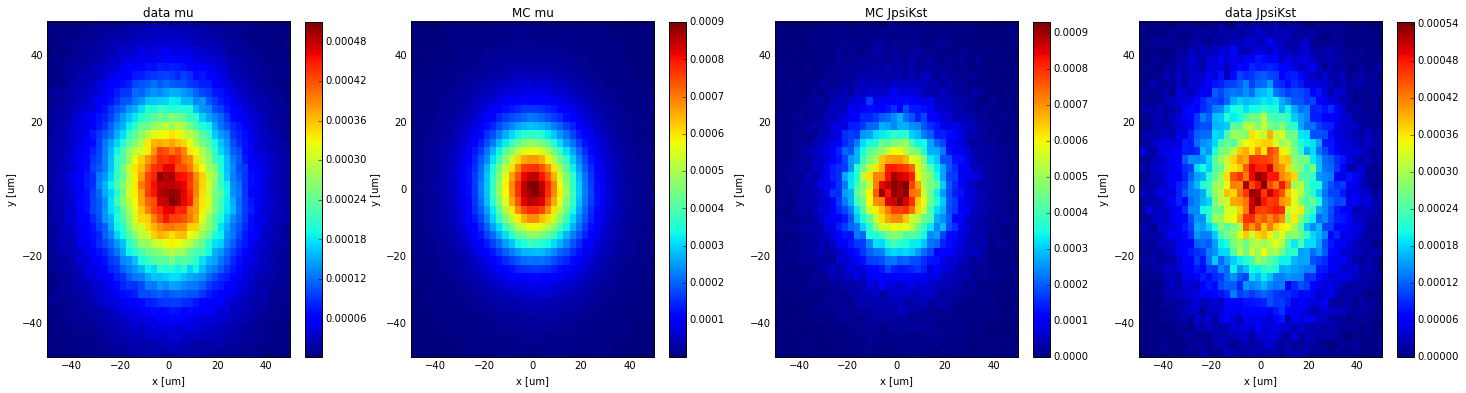

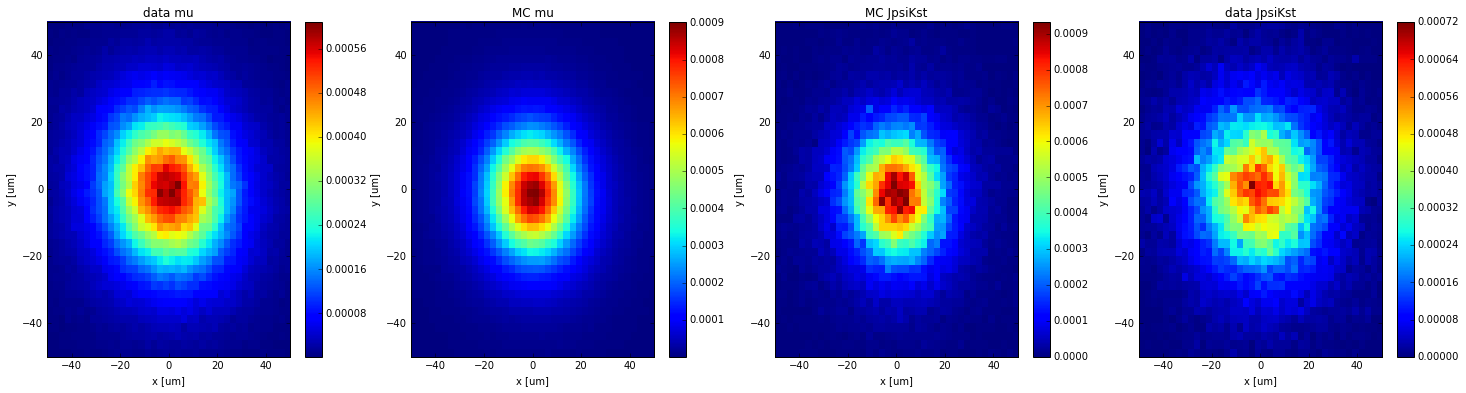

In [8]:
bounds = ((-50, 50), (-50, 50))
nBins = 40
for vAux, ref in [['', 'Mean'], ['bs', 'BS']]:
    fig, axs = plt.subplots(1, 4, figsize=(25, 6))
    xVar = 'vtxC'+vAux+'_x'
    yVar = 'vtxC'+vAux+'_y'
    h = axs[0].hist2d(df['data'][xVar], df['data'][yVar], range=bounds, bins=nBins, normed=True)
    axs[0].set_title('data mu')
    fig.colorbar(h[3], ax=axs[0])
    h = axs[1].hist2d(df['mu'][xVar], df['mu'][yVar], range=bounds, bins=nBins, normed=True, weights=df['mu']['w'])
    axs[1].set_title('MC mu')
    fig.colorbar(h[3], ax=axs[1])
    h = axs[2].hist2d(df['JpsiKst'][xVar], df['JpsiKst'][yVar], range=bounds, bins=nBins, normed=True, weights=df['JpsiKst']['w'])
    axs[2].set_title('MC JpsiKst')
    fig.colorbar(h[3], ax=axs[2])
    h = axs[3].hist2d(df['data_JpsiKst'][xVar], df['data_JpsiKst'][yVar], range=bounds, bins=nBins, normed=True)
    axs[3].set_title('data JpsiKst')
    fig.colorbar(h[3], ax=axs[3])
    for ax in axs:
        ax.set_xlabel('x [um]')
        ax.set_ylabel('y [um]')
    fig.savefig(webDir + '/vertex_2D_ref'+ref+'_pre_'+category+'.png', bbox_inches='tight')

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


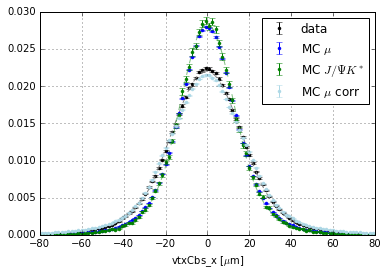

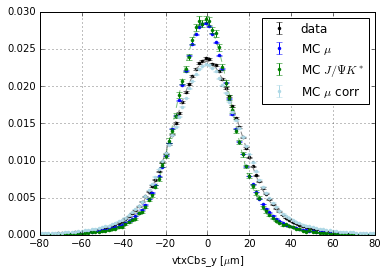

In [9]:
param = {}
bbb = [100, -80, 80]
if vtxReference == 'bs':
    vvv = 'vtxCbs'
elif vtxReference == 'mean':
    vvv = 'vtxC'
for n in [vvv+'_x', vvv+'_y']:
    plt.figure()
    h = create_TH1D(df['data'][n], binning=bbb, scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    sData = np.std(df['data'][n])
    parData, cov = sp.optimize.curve_fit(doubleCrystalball, r[:,0], r[:,1], p0=[0, 0.8*sData, 1.5, 1.5], sigma=r[:,2])
    h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', color='k', label='data')
    plt.plot(r[:,0], doubleCrystalball(r[:,0], *parData), color='gray', ls='--')

    h = create_TH1D(df['mu'][n], binning=bbb, weights=df['mu']['w'], scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    sMC = np.std(df['mu'][n])
    h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', color='blue', label=r'MC $\mu$')
    
    h = create_TH1D(df['JpsiKst'][n], binning=bbb, weights=df['JpsiKst']['w'], scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    sMC = np.std(df['JpsiKst'][n])
    parMC, cov = sp.optimize.curve_fit(doubleCrystalball, r[:,0], r[:,1], p0=[0, 0.8*sMC, 1.5, 1.5], sigma=r[:,2])
    h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', color='green', label=r'MC $J/\Psi K^*$')
    plt.plot(r[:,0], doubleCrystalball(r[:,0], *parMC), color='green', alpha=0.5, ls='--')

    widthCorr = getBeamSpotWeights(df['mu'], n[-1], parData, parMC, ref=vtxReference)
    h = create_TH1D(df['mu'][n], binning=bbb, weights=df['mu']['w']*widthCorr, scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label=r'MC $\mu$ corr', color='lightblue')

    plt.legend(loc='best', numpoints=1)
    plt.xlabel(n + r' [$\mu$m]')
    plt.grid()
    plt.savefig(webDir + '/vertex_1D_'+n[-1]+'_pre_'+category+'.png', bbox_inches='tight')
    
    param[n[-1]] = {'data':parData, 'MC':parMC}

In [10]:
param

{'x': {'MC': array([-0.13440531, 13.20238009,  1.40895962, 14.54303729]),
  'data': array([-0.39160787, 17.16368057,  1.45181824, 20.72500933])},
 'y': {'MC': array([-1.52340663, 13.09529072,  1.46484475, 11.44696868]),
  'data': array([-0.33081403, 16.09899491,  1.42458318, 16.63952151])}}

In [11]:
out = {}
for k in param.keys():
    out[k] = {}
    for kk in param[k].keys():
        out[k][kk] = [float(x) for x in param[k][kk]]
from datetime import datetime
fname = '/storage/af/group/rdst_analysis/BPhysics/data/calibration/beamSpot/crystalball_calibration_'+version+'_'+category+'.yaml'
with open(fname, 'w') as f:
    f.write('# Calibration of beam spot using independent CB approx\n')
    f.write('# pars = [mu, sigma, beta, m]\n')
    f.write('# '+datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '\n')
    f.write(yaml.dump(out))
    
param = yaml.load(open(fname, 'r'))
print param

{'y': {'data': [-0.33081402520234904, 16.09899490927931, 1.424583183217668, 16.639521511400005], 'MC': [-1.5234066341326933, 13.095290715960049, 1.4648447506438733, 11.44696867568374]}, 'x': {'data': [-0.391607868325708, 17.163680573938397, 1.451818239895769, 20.725009334134043], 'MC': [-0.13440531066059236, 13.202380092898485, 1.4089596169976268, 14.543037292039573]}}


In [12]:
df['JpsiKst']['w_width'] = getBeamSpotCorrectionWeights(df['JpsiKst'], param, ref=vtxReference)

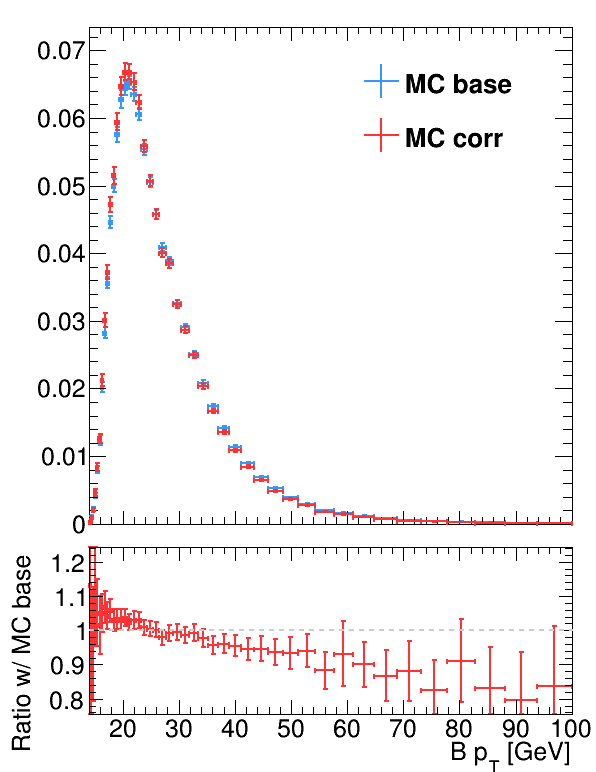

In [13]:
auxDf = df['JpsiKst']
lowOff = 5
midOff = 10
highOff = 5
b = {'Low': array('d', list( lowOff+np.logspace(np.log10(12-lowOff), np.log10(90-lowOff), 40) )),
     'Mid': array('d', list( midOff+np.logspace(np.log10(14-midOff), np.log10(100-midOff), 45) )),
     'High': array('d', list( highOff+np.logspace(np.log10(18-highOff), np.log10(125-highOff), 50) )),
    }

h_base = create_TH1D(auxDf['B_pt'], 'MC base', weights=auxDf['w'], 
                     color=0, binning=b[category], widthNorm=True, scale_histo='norm')

h_corr = create_TH1D(auxDf['B_pt'], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=1, binning=b[category], widthNorm=True, scale_histo='norm')


h_base.SetXTitle('B p_{T} [GeV]')
c = make_ratio_plot([h_base, h_corr], ratio_bounds='auto', 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

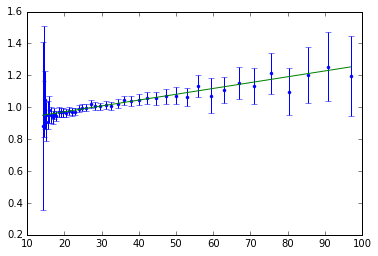

In [14]:
h_ratio = h_base.Clone('h_ratio')
h_ratio.Divide(h_corr)
r = rootTH1_to_np(h_ratio)

h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.')
pt_p = np.polyfit(x=r[:,0], y=r[:,1], deg=1, w=1./r[:,2])
plt.plot(r[:,0], np.polyval(pt_p, r[:,0]), color='green')

In [15]:
df['JpsiKst']['w_pt'] = np.polyval(pt_p, df['JpsiKst']['B_pt'])

Warning in <TROOT::Append>: Replacing existing TH1: MC base (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC corr (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


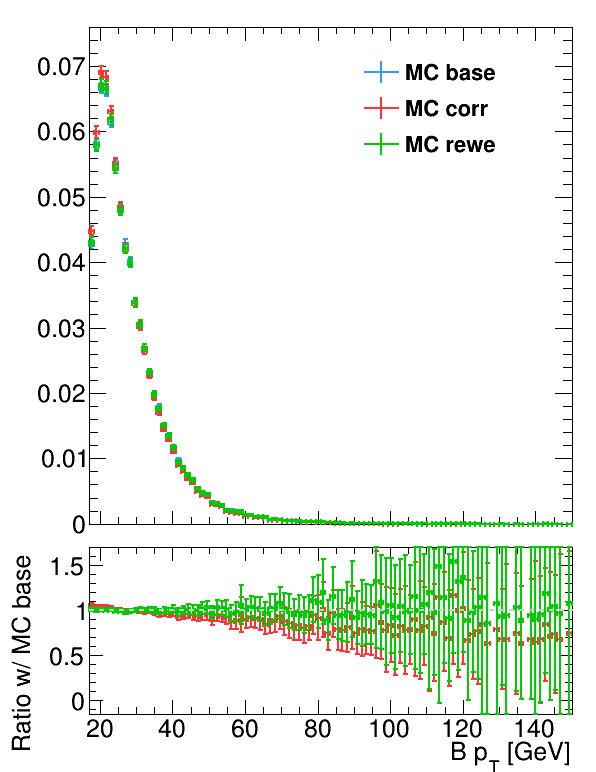

In [16]:
auxDf = df['JpsiKst']
h_base = create_TH1D(auxDf['B_pt'], 'MC base', weights=auxDf['w'], 
                     color=0, binning=[100,17,150], widthNorm=True, scale_histo='norm')

h_corr = create_TH1D(auxDf['B_pt'], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=1, binning=[100,17,150], widthNorm=True, scale_histo='norm')

h_rewe = create_TH1D(auxDf['B_pt'], 'MC rewe', weights=auxDf['w']*auxDf['w_width']*auxDf['w_pt'],
                     color=2, binning=[100,17,150], widthNorm=True, scale_histo='norm')


h_base.SetXTitle('B p_{T} [GeV]')
c = make_ratio_plot([h_base, h_corr, h_rewe], ratio_bounds='auto', 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

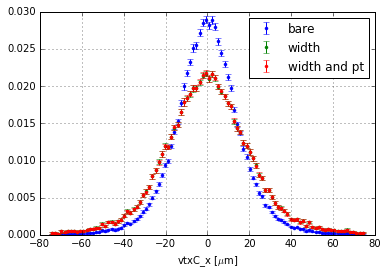

In [17]:
n = 'vtxC_x'
x = df['JpsiKst'][n]

h = create_TH1D(x, binning=[100, -75, 75], weights=df['JpsiKst']['w'], scale_histo='norm', widthNorm=True)
r = rootTH1_to_np(h)
h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label='bare')

h = create_TH1D(x, binning=[100, -75, 75], weights=df['JpsiKst']['w']*df['JpsiKst']['w_width'], scale_histo='norm', widthNorm=True)
r = rootTH1_to_np(h)
h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label='width')

h = create_TH1D(x, binning=[100, -75, 75], weights=df['JpsiKst']['w']*df['JpsiKst']['w_width']*df['JpsiKst']['w_pt'], scale_histo='norm', widthNorm=True)
r = rootTH1_to_np(h)
h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label='width and pt')

plt.legend(loc='best', numpoints=1)
plt.xlabel(n + r' [$\mu$m]')
plt.grid()

# Check effect on missing mass

In [18]:
df['mu']['w_width'] = getBeamSpotCorrectionWeights(df['mu'], param, ref=vtxReference)

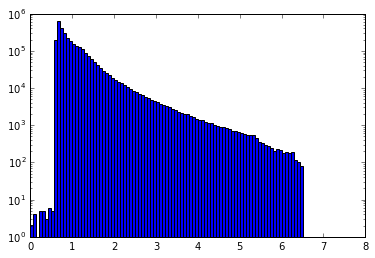

In [19]:
plt.hist(df['mu']['w_width'], bins=100, range=(0,1.1*np.max(df['mu']['w_width'])))
plt.yscale('log')

In [20]:
print 'Normalization difference:', np.sum(df['mu']['w_width'])/float(df['mu'].shape[0])

Normalization difference: 1.0612554041607398


In [21]:
np.percentile(df['mu']['w_width'], 99.9)

5.455299453378085

In [22]:
print np.sort(df['mu']['w_width'])[-10:]

[6.48867102 6.48951198 6.48960465 6.49040241 6.49326046 6.49344702
 6.49699983 6.49739122 6.49929243 6.50091335]


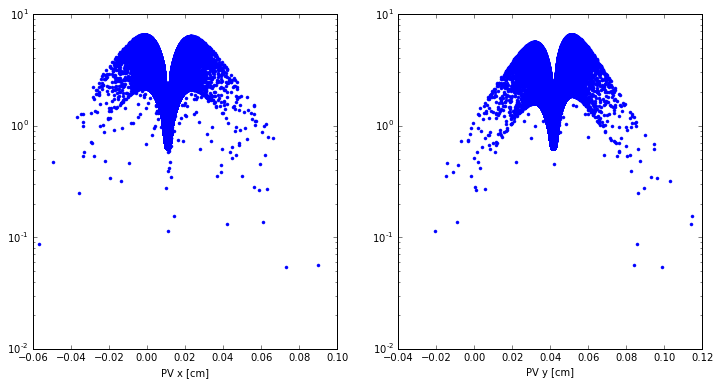

In [23]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(12, 6))

ax.plot(df['mu']['vtx_PV_x'], df['mu']['w_width'], '.')
ax.set_yscale('log')
ax.set_xlabel('PV x [cm]')

ay.plot(df['mu']['vtx_PV_y'], df['mu']['w_width'], '.')
ay.set_yscale('log')
ay.set_xlabel('PV y [cm]')

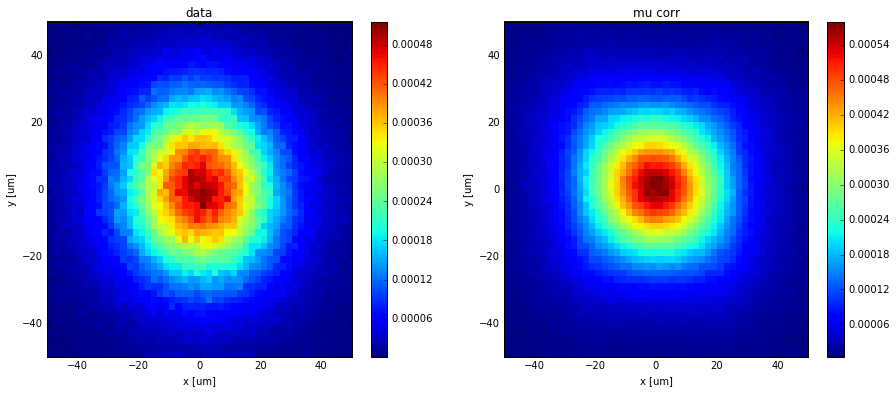

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

bounds = ((-50, 50), (-50, 50))
h = axs[0].hist2d(df['data']['vtxC_x'], df['data']['vtxC_y'], range=bounds, bins=50, normed=True)
fig.colorbar(h[3], ax=axs[0])
h = axs[1].hist2d(df['mu']['vtxC_x'], df['mu']['vtxC_y'], range=bounds, bins=50, normed=True, 
                  weights=df['mu']['w']*df['mu']['w_width'])
fig.colorbar(h[3], ax=axs[1])
axs[0].set_title('data')
axs[1].set_title('mu corr')
for ax in axs:
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
fig.savefig(webDir + '/vertex_2D_post_'+category+'.png', bbox_inches='tight')

In [25]:
sel = df['mu']['q2'] < binning['q2'][1]
auxDf = df['mu'][sel]

Warning in <TROOT::Append>: Replacing existing TH1: MC base (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC corr (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


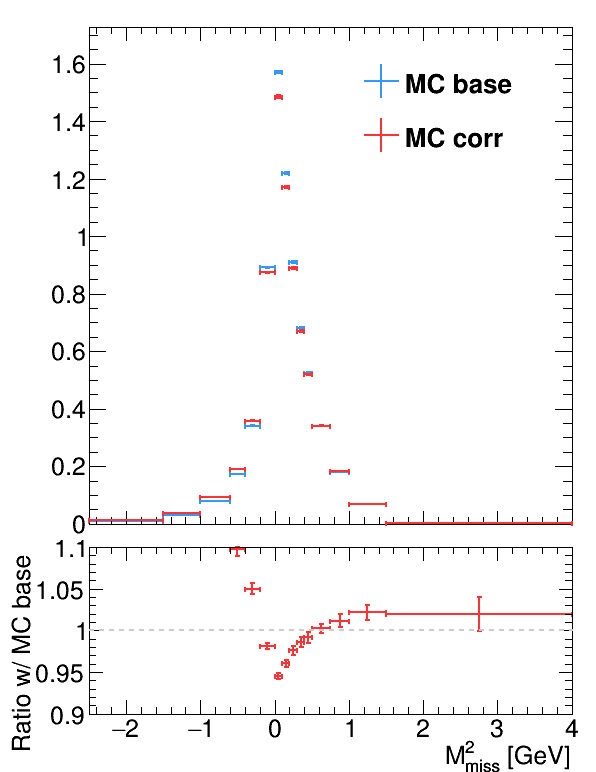

In [26]:
h_base = create_TH1D(auxDf['M2_miss'][sel], 'MC base', weights=auxDf['w'], 
                     color=0, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

h_corr = create_TH1D(auxDf['M2_miss'][sel], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=1, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


h_base.SetXTitle('M^{2}_{miss} [GeV]')
c = make_ratio_plot([h_base, h_corr], ratio_bounds=[0.9, 1.1], 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

0.0
25.714285714285715
51.42857142857143
77.14285714285714
102.85714285714286
128.57142857142858
154.28571428571428
180.0


Warning in <TROOT::Append>: Replacing existing TH1: Up (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Dw (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC corr (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio_phi0
Warning in <TROOT::Append>: Replacing existing TH1: Up (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Dw (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC corr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Up (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Dw (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC corr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Up (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Dw (Potential memory leak).
Warning in <TROOT::Ap

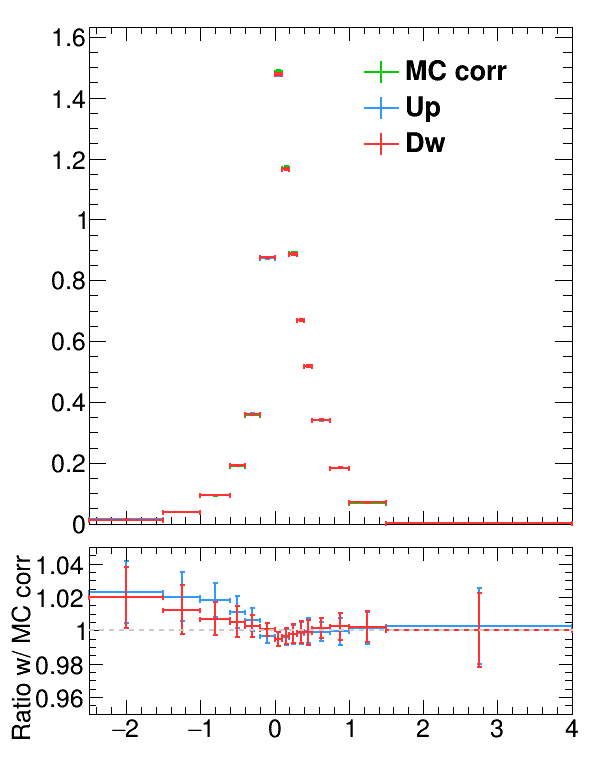

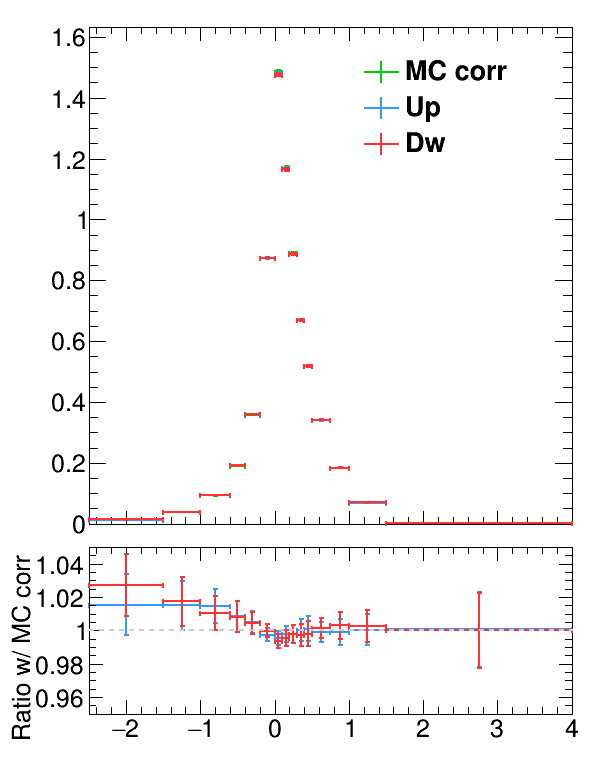

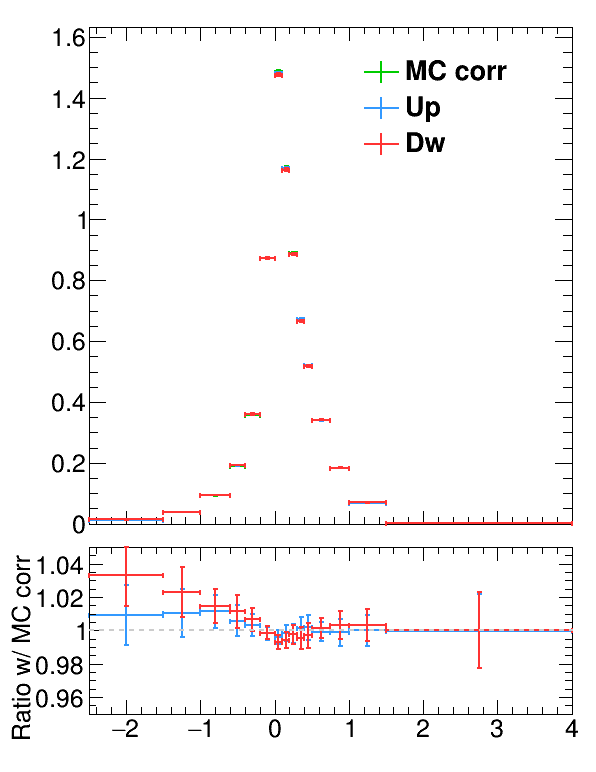

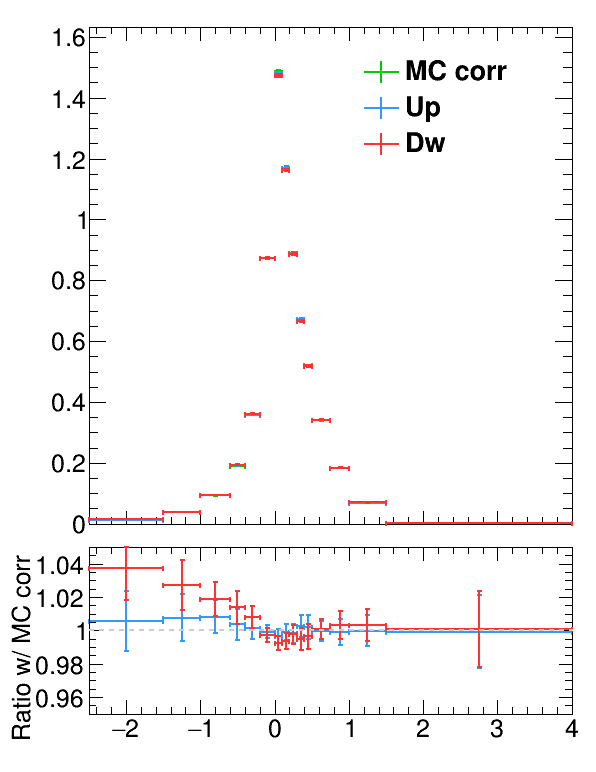

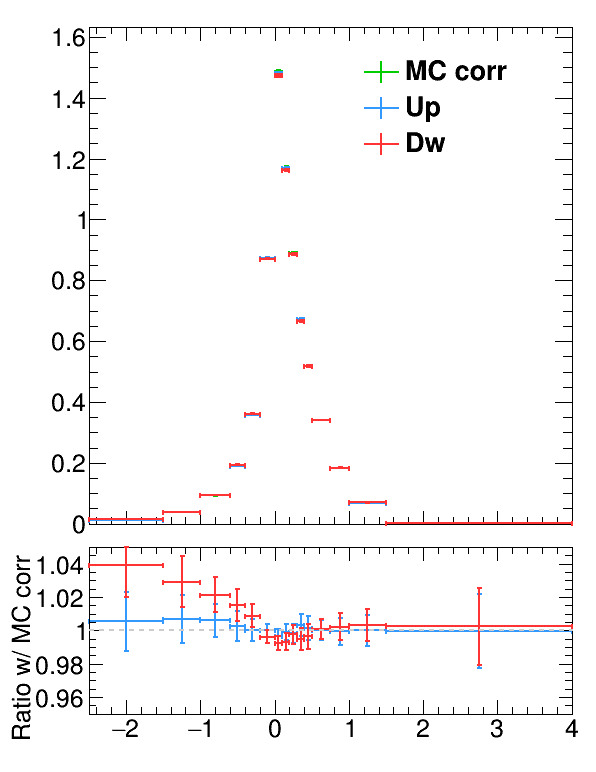

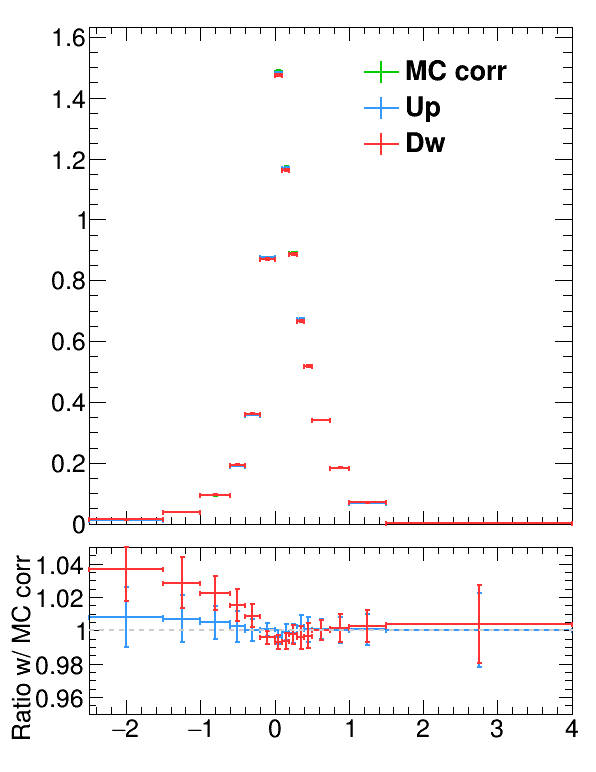

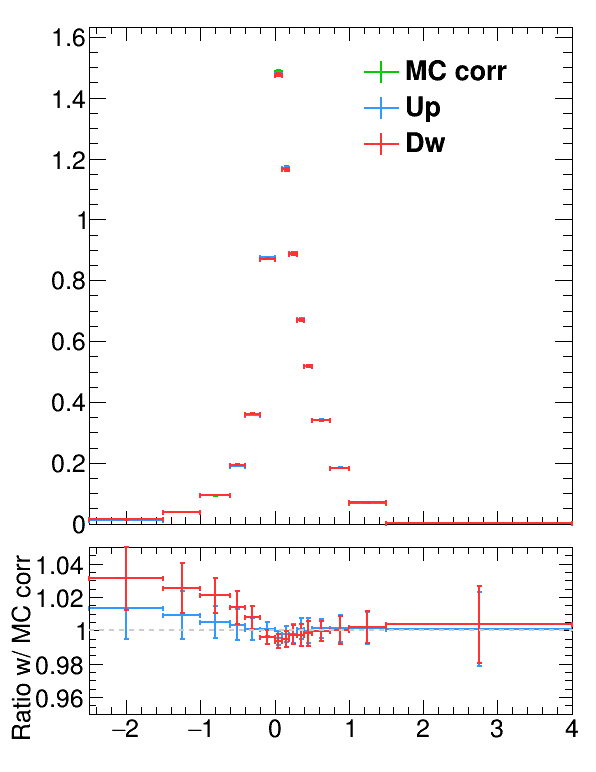

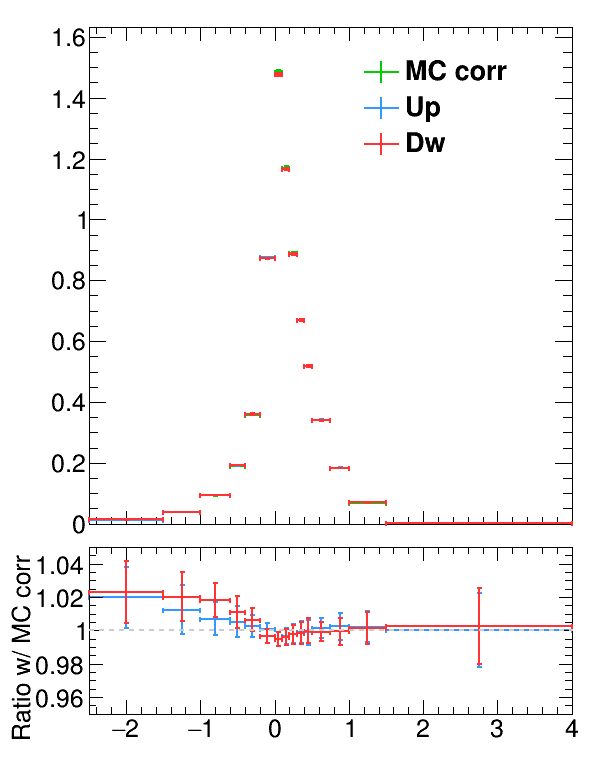

In [30]:
r = 5
phi = 45 + 90
for phi in np.linspace(0, 180, 8):
    print phi
    dx = r*np.cos(np.deg2rad(phi))
    dy = r*np.sin(np.deg2rad(phi))

    auxW = getBeamSpotCorrectionWeights(auxDf, param, ref=vtxReference, dmu_x=-dx, dmu_y=-dy)
    h_xDw = create_TH1D(auxDf['M2_miss'][sel], 'Up', weights=auxDf['w']*auxW,
                        color=0, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

    auxW = getBeamSpotCorrectionWeights(auxDf, param, ref=vtxReference, dmu_x=dx, dmu_y=dy)
    h_xUp = create_TH1D(auxDf['M2_miss'][sel], 'Dw', weights=auxDf['w']*auxW,
                        color=1, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


    h_corr = create_TH1D(auxDf['M2_miss'][sel], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                         color=2, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


    h_base.SetXTitle('M^{2}_{miss} [GeV]')
    c = make_ratio_plot([h_corr, h_xDw, h_xUp], ratio_bounds=[0.95, 1.05], label='_phi'+str(int(phi)),
                        leg_pos=[0.6, 0.7, 0.92, 0.9])
    c.Draw()
    donotdelete.append(c)